# Interpret LightGBM Classifier with SHAP: Spaceship Titanic Dataset

## Introduction

This notebook demonstrates how to utilize SHAP (SHapley Additive exPlanations) to interpret complex gradient-boosted models, specifically LightGBM. The purpose is to make the results of these models more interpretable to both yourself and stakeholders. SHAP provides a unified framework to explain the output of any machine learning model, helping you understand the contribution of each feature to the predictions.

## Table of Contents

1. [Data Preparation](#data-preparation)
   - [Import Data and Modules](#import-data-and-modules)
   - [Basic Exploratory Data Analysis (EDA)](#basic-exploratory-data-analysis) 
   - [Feature Engineering](#feature-engineering)
   - [Data Cleaning](#data-cleaning)
2. [Modeling](#modeling)
   - [Data Preprocessing for Modeling](#data-preprocessing-for-modeling)
   - [Model Training](#model-training)
   - [Model Evaluation](#model-evaluation)
3. [Interpretability](#interpretability)
   - [SHAP Analysis](#shap-analysis)

# 1) Data Preparation
<a id="data-preparation"></a>

## Import Data and Modules
<a id="import-data-and-modules"></a>

In [1]:
# base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling and evaluation
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap
import os

In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df = pd.concat([train, test], ignore_index=True)

## Basic Exploratory Data Analysis (EDA)
<a id="basic-exploratory-data-analysis"></a>

### 1. Data Description

> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.<br>
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
> * **Destination** - The planet the passenger will be debarking to.<br>
> * **Age** - The age of the passenger.<br>
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.<br>
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
> * **Name** - The first and last names of the passenger.<br>
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br>

### 2. Dataframe Structure

In [3]:
df.shape

(17386, 14)

### 3. Count Transported Passengers In Training Dataset

In [4]:
transported_counts = train['Transported'].value_counts()
total_passengers = len(train)
transported_percentage = ((transported_counts / total_passengers) * 100).round(2)

transported_df = pd.DataFrame({
    'Count': transported_counts,
    'Percentage': transported_percentage
})

transported_df

,Count,Percentage
Transported,,
True,4378,50.36
False,4315,49.64


### 4. View Merged Dataframe

In [5]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### 5. View Summary Statistics of Continuous Features

In [6]:
summary_stats = df.describe().apply(lambda x: x.round().astype(int))
summary_stats

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,17028,17024,17020,16970,17020,17010
mean,29,225,458,174,311,305
std,14,667,1611,605,1137,1146
min,0,0,0,0,0,0
25%,19,0,0,0,0,0
50%,27,0,0,0,0,0
75%,38,47,76,27,59,46
max,79,14327,29813,23492,22408,24133


### 6. View Distribution of Categorical Features

In [7]:
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin']

counts_dict = {}

for feature in categorical_features:
    if feature in df.columns:
        counts_dict[feature] = df[feature].value_counts()
    else:
        counts_dict[feature] = 'Feature not found in the dataset.'

for feature, counts in counts_dict.items():
    print(f'Counts for {feature}:')
    if isinstance(counts, pd.Series):
        display(pd.DataFrame(counts).reset_index().rename(columns={'index': feature, feature: 'count'}))
    else:
        print(counts)
    print('\n')

Counts for HomePlanet:


,count,count
0,Earth,9204
1,Europa,4262
2,Mars,3518




Counts for CryoSleep:


,count,count
0,False,10878
1,True,6074




Counts for Destination:


,count,count
0,TRAPPIST-1e,11830
1,55 Cancri e,3600
2,PSO J318.5-22,1592




Counts for VIP:


,count,count
0,False,16582
1,True,398




Counts for Cabin:


,count,count
0,G/734/S,16
1,G/109/P,14
2,B/201/P,14
3,G/1368/P,14
4,G/981/S,14
...,...,...
6555,G/556/P,2
6556,E/231/S,2
6557,G/545/S,2
6558,G/543/S,2


### 7. Check for Missing Values

In [8]:
# Calculate missing values and their percentage
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}).round(1)
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

missing_df

,Missing Values,Percentage
CryoSleep,434,2.5
ShoppingMall,416,2.4
VIP,406,2.3
HomePlanet,402,2.3
Name,400,2.3
Cabin,398,2.3
VRDeck,376,2.2
FoodCourt,366,2.1
Spa,366,2.1
Destination,364,2.1


## Feature Engineering
<a id="feature-engineering"></a>

### 1. Create Group Size Feature Using Cabin

In [9]:
df['group_size'] = df.groupby('Cabin')['Cabin'].transform('count')

df['group_size'].head()

0    2.0
1    2.0
2    4.0
3    4.0
4    2.0
Name: group_size, dtype: float64

In [10]:
df['group_size'].describe()

count    16988.000000
mean         3.564869
std          2.682723
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
Name: group_size, dtype: float64

### 2. Break Out Cabin Into Deck / Number / Side

In [11]:
def split_cabin(cabin):
    if pd.isna(cabin):
        return pd.Series([None, None, None])
    parts = cabin.split('/')
    deck = parts[0]
    number = parts[1]
    side = 'Port' if parts[2] == 'P' else 'Starboard'
    return pd.Series([deck, number, side])

df[['cabin_deck', 'cabin_number', 'cabin_side']] = df['Cabin'].apply(split_cabin)

In [12]:
cabin_cols = ['cabin_deck', 'cabin_side']

counts_dict = {}

for feature in cabin_cols:
    if feature in df.columns:
        counts_dict[feature] = df[feature].value_counts()
    else:
        counts_dict[feature] = 'Feature not found in the dataset.'

for feature, counts in counts_dict.items():
    print(f'Counts for {feature}:')
    if isinstance(counts, pd.Series):
        display(pd.DataFrame(counts).reset_index().rename(columns={'index': feature, feature: 'count'}))
    else:
        print(counts)
    print('\n')

Counts for cabin_deck:


,count,count
0,F,5588
1,G,5118
2,E,1752
3,B,1558
4,C,1494
5,D,956
6,A,512
7,T,10




Counts for cabin_side:


,count,count
0,Starboard,8576
1,Port,8412


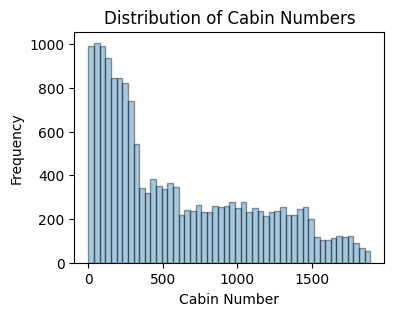

In [13]:
# Convert cabin_number to numeric, coerce errors to NaN
df['cabin_number'] = pd.to_numeric(df['cabin_number'], errors='coerce')

# Drop rows with NaN values in cabin_number for the histogram
df = df.dropna(subset=['cabin_number'])

# Plot the histogram of cabin_number
plt.figure(figsize=(4, 3))
plt.hist(df['cabin_number'], bins=50, edgecolor='k', alpha=0.4)
plt.title('Distribution of Cabin Numbers')
plt.xlabel('Cabin Number')
plt.ylabel('Frequency')
plt.show()

### 3. Create Total Spend Feature and Spend Groupings

#### 3a. Create Total Spend Feature

In [14]:
expenditure_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['total_spend'] = df[expenditure_columns].sum(axis=1)

#### 3b. Create Total Spend by Group Feature

In [15]:
df['total_group_spend'] = df.groupby('Cabin')['total_spend'].transform('sum')

In [16]:
df['total_group_spend'].describe()

count     16988.000000
mean       5448.120556
std       10635.691084
min           0.000000
25%           0.000000
50%        1730.000000
75%        4826.000000
max      105336.000000
Name: total_group_spend, dtype: float64

#### 3c. Bin Total Passenger Spend

In [17]:
# Bin total_spend into categories
bins = [-1, 0, 500, 2000, float('inf')]
labels = ['no_spend', 'low_spend', 'med_spend', 'high_spend']
df['trip_spend'] = pd.cut(df['total_spend'], bins=bins, labels=labels)

df['trip_spend'].value_counts()

trip_spend
no_spend      7112
med_spend     6412
high_spend    3254
low_spend      210
Name: count, dtype: int64

#### 3d. Bin Total Group Spend

In [18]:
# Bin total_spend into categories
bins = [-1, 0, 1500, 4500, float('inf')]
labels = ['no_spend', 'low_spend', 'med_spend', 'high_spend']
df['group_spend'] = pd.cut(df['total_group_spend'], bins=bins, labels=labels)

df['group_spend'].value_counts()

group_spend
med_spend     5602
no_spend      5220
high_spend    4472
low_spend     1694
Name: count, dtype: int64

### 4. Bin Age

In [19]:
# Bin age into categories with new labels
age_bins = [0, 12, 20, 30, 45, 64, float('inf')]
age_labels = ['age_kid', 
              'age_teen', 
              'age_young_adult', 
              'age_adult', 
              'age_middle_age', 
              'age_senior']

df['age_category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

df.drop(columns=['Age'], inplace=True)

In [20]:
# Plot for age_category
df['age_category'].value_counts()

age_category
age_young_adult    5218
age_adult          4410
age_teen           3182
age_middle_age     2046
age_kid            1228
age_senior          204
Name: count, dtype: int64

In [21]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,group_size,cabin_deck,cabin_number,cabin_side,total_spend,total_group_spend,trip_spend,group_spend,age_category
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,...,False,2.0,B,0.0,Port,0.0,0.0,no_spend,no_spend,age_adult
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,...,True,2.0,F,0.0,Starboard,736.0,1472.0,med_spend,low_spend,age_young_adult
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,...,False,4.0,A,0.0,Starboard,10383.0,31118.0,high_spend,high_spend,age_middle_age
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,...,False,4.0,A,0.0,Starboard,5176.0,31118.0,high_spend,high_spend,age_adult
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,...,True,2.0,F,1.0,Starboard,1091.0,2182.0,med_spend,med_spend,age_teen


## Data Cleaning
<a id="data-cleaning"></a>

### 1. Drop Columns

In [22]:
drop_cols = ['Cabin', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
             'RoomService', 'total_spend', 'total_group_spend', 'Name']

df.drop(columns=drop_cols, inplace=True)

In [23]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,Transported,group_size,cabin_deck,cabin_number,cabin_side,trip_spend,group_spend,age_category
0,0001_01,Europa,False,TRAPPIST-1e,False,False,2.0,B,0.0,Port,no_spend,no_spend,age_adult
1,0002_01,Earth,False,TRAPPIST-1e,False,True,2.0,F,0.0,Starboard,med_spend,low_spend,age_young_adult
2,0003_01,Europa,False,TRAPPIST-1e,True,False,4.0,A,0.0,Starboard,high_spend,high_spend,age_middle_age
3,0003_02,Europa,False,TRAPPIST-1e,False,False,4.0,A,0.0,Starboard,high_spend,high_spend,age_adult
4,0004_01,Earth,False,TRAPPIST-1e,False,True,2.0,F,1.0,Starboard,med_spend,med_spend,age_teen


### 1. Deal with Missing Values

# 2) Modeling
<a id="modeling"></a>

### Data Preprocessing for Modeling
<a id="data-preprocessing-for-modeling"></a>

### Model Training
<a id="model-training"></a>

### Model Evaluation
<a id="model-evaluation"></a>

# 3) Interpretability
<a id="interpretability"></a>

### SHAP Analysis
<a id="shap-analysis"></a>